# DisCoPy: Distributional Compositional Python

## A toolbox for quantum computing, linguistics and applied category theory

$\quad$

Alexis TOUMI

QNLP conference

30$^\text{th}$ of May 2022

$\quad$

**Outline:**

1. Diagrams as a data structure for quantum and linguistics
2. Functors for high-level & high-performance computation
3. Diagrammatic differentiation for QNLP

$$\qquad$$

**References:**

* **_DisCoPy: monoidal categories in Python_**, jww G. de Felice and B. Coecke ([arXiv:2005.02975](https://arxiv.org/abs/2005.02975))
* **_DisCoPy for the quantum computer scientist_**, jww G. de Felice and R. Yeung ([arXiv:2205.05190](https://arxiv.org/pdf/2205.05190))
* **_Category theory for quantum natural language processing_**, PhD thesis (to appear)

$\quad$

## 2. Diagrams as a data structure

**Definition:** A monoidal signature is a tuple $\Sigma = (\Sigma_0, \Sigma_1, \text{dom}, \text{cod})$ where:
* $\Sigma_0$ is a set of **wires**,
* $\Sigma_1$ is a set of **boxes**,
* $\text{dom}, \text{cod} : \Sigma_1 \to \Sigma_0^\star$ are the **input** and **output** wires for each box.

**Definition:** A layer is a triple $L(\Sigma) = \Sigma_0^\star \times \Sigma_1 \times \Sigma_0^\star$.

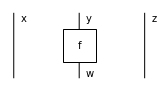

In [1]:
from discopy import Ty, Box, Id

x, y, z, w = map(Ty, "xyzw")
f = Box(name='f', dom=y, cod=w)
layer = Id(x) @ f @ Id(z)

layer.draw(aspect='equal', figsize=(2, 2))

**Definition:** A diagram $d$ is given by:
* a domain $\text{dom}(d) \in \Sigma_1^\star$,
* a list of **composable** layers $\text{layers}(d) = d_1, \dots, d_n \in \Sigma_1^\star$ such that
    - $\text{dom}(d) = \text{dom}(d_0)$ and
    - $\text{dom}(d_{i + 1}) = \text{cod}(d_i)$ for $i \leq n$.
    
We can compose diagrams:
* in sequence with `>>`,
* and in parallel with `@`.

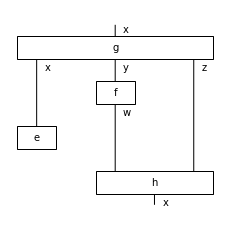

In [2]:
g, h = Box('g', x, x @ y @ z), Box('h', w @ z, x)
e = Box('e', x, Ty())

diagram = g >> layer >> e @ h

diagram.draw(figsize=(3, 3))

Sometimes two diagrams represent the same process.

DisCoPy performs **diagram rewriting** which can be used to:
* check equality of two diagrams,
* find the optimal diagram for a given process.

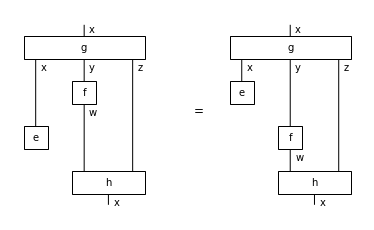

In [3]:
from discopy import drawing

drawing.equation(
    diagram, diagram.normal_form(),                                figsize=(5, 3))

We can add special kinds of boxes for:
* swaps,
* cups and caps,
* spiders,
* ...

which all come with new kinds of rewrites.

### Diagrams for computational linguistics

We can represent any kind of grammatical framework in terms of diagrams.

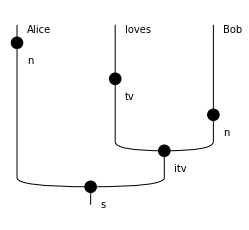

In [4]:
V = Alice, loves, Bob = map(Ty, 'Alice loves Bob'.split())
X = s, n, tv, itv = map(Ty, 's n tv itv'.split())

R = [Box('', tv @ n, itv),
     Box('', n @ itv, s),
     Box('', Alice, n),
     Box('', loves, tv),
     Box('', Bob, n)]

for r in R: r.draw_as_spider, r.color = True, "black"

tree = R[2] @ R[3] @ R[4] >> Id(n) @ R[0] >> R[1]
tree.draw(figsize=(3, 3))

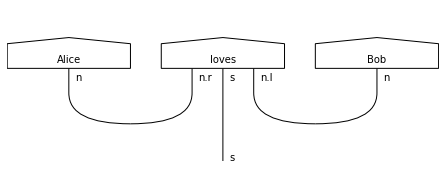

In [5]:
from discopy import pregroup, Word, Cup

s, n = Ty('s'), Ty('n')
Alice, Bob = Word('Alice', n), Word('Bob', n)
loves = Word('loves', n.r @ s @ n.l)

sentence = Alice @ loves @ Bob >> Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
pregroup.draw(sentence)

### Diagrams for quantum computing

We can represent any kind of quantum process in terms of diagrams.

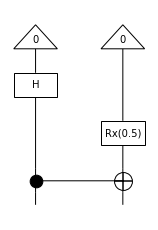

In [6]:
from discopy.quantum import CX, H, Rx, Ket, sqrt

circuit = Ket(0, 0) >> H @ Rx(0.5) >> CX
circuit.draw(figsize=(2, 3))

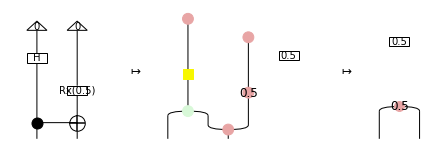

In [7]:
from discopy.quantum.zx import circuit2zx, X, scalar

drawing.equation(
    circuit, circuit2zx(circuit), scalar(0.5) @ X(0, 2, .5), figsize=(6, 2), symbol='$\mapsto$')

... and we keep on adding tools to the toolbox!

* classical-quantum processes (all of Bob's dodo book in Python),
* from qubits to arbitrary-dimensional qudits,
* differentiation of diagrams with symbolic parameters,
* quantum linear optical computing (coming soon!)

## 2. Functors for computation

**Definition:** A functor `F` is given by:
* an object mapping `F.ob` from types to types,
* an arrow mapping `F.ar` from boxes to diagrams.

**Examples:**
* The `circuit2zx` mapping above.
* Qubit encoding for photonics.
* QNLP models!

Circuit for 'Alice loves Bob':


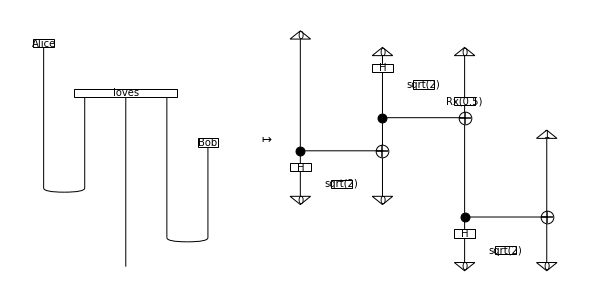

In [8]:
from discopy import CircuitFunctor, qubit

def verb_ansatz(phase):
    return Ket(0, 0) >> H @ sqrt(2) @ Rx(phase) >> CX

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1),
    loves: verb_ansatz(params['loves'])}

F = lambda params: CircuitFunctor(ob, ar(params))

params = {'loves': 0.5}

print("Circuit for 'Alice loves Bob':")
drawing.equation(
    sentence, F(params)(sentence), symbol='$\mapsto$',
    aspect='auto', draw_type_labels=False, figsize=(8, 4))

Different ways of evaluating functors:

* executing them on quantum devices with:
    - t$\vert$ket$\rangle$,
* high-performance classical simulation with
    - JAX,
    - pytorch,
    - tensorflow,
    - tensornetwork,
    - etc.

## 3. Diagrammatic differentiation for QNLP

Where do we get the parameters for our functor?

We need gradients!

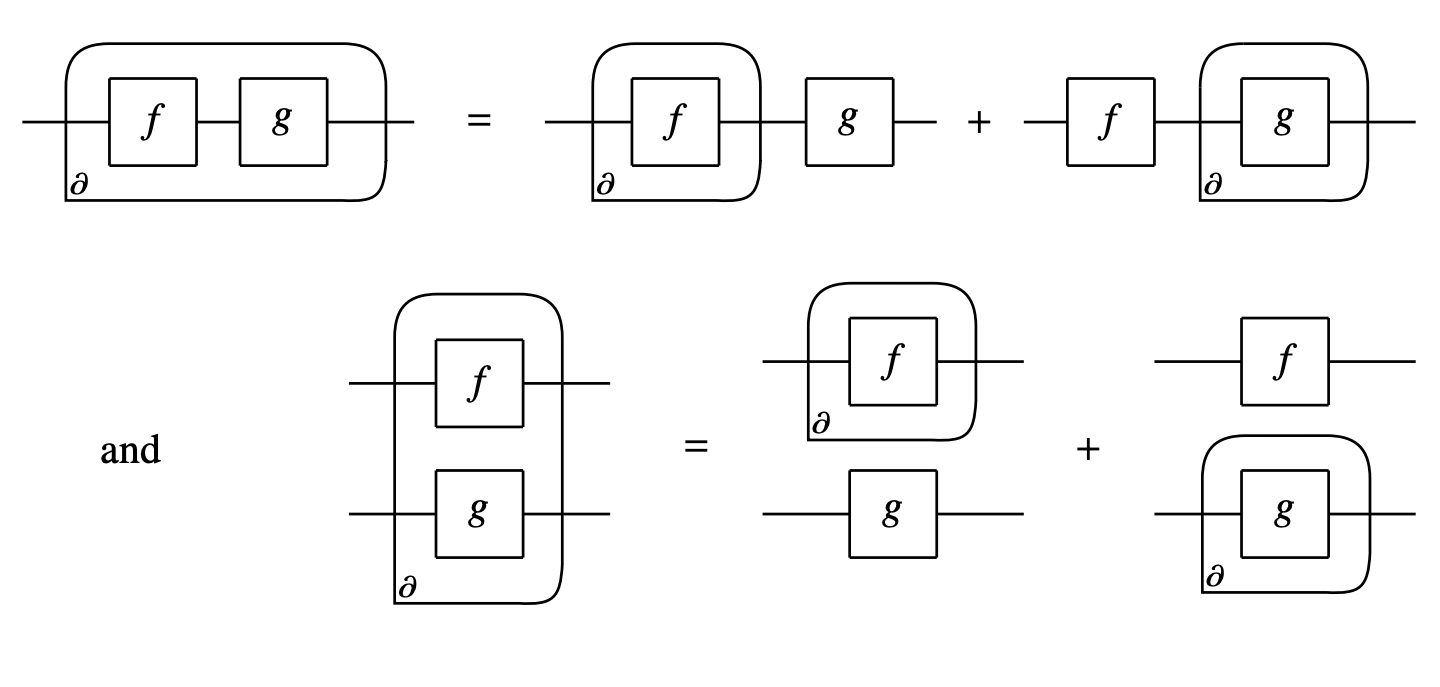

**Theorem:**
The ZX-calculus with affine maps $\mathbb{R}^n \to \mathbb{R}$ as phases admits diagrammatic differentiation.

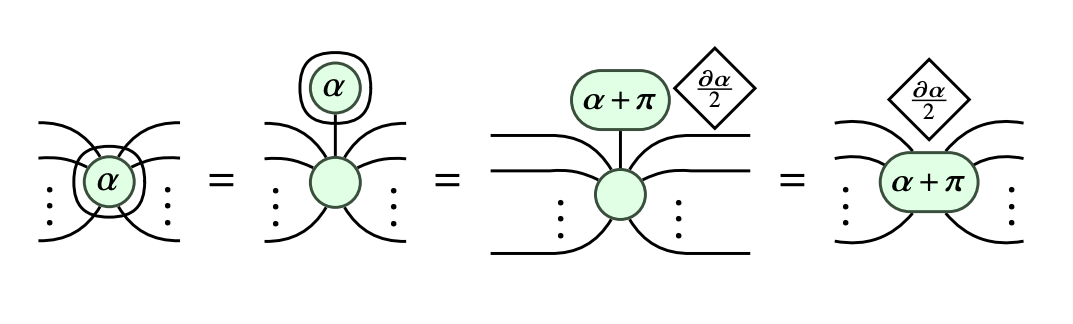

**Remark:** A diagrammatic derivation for pure processes does not in general lift to one for classical-quantum circuits. Indeed, from the product rule we get
$\partial \big( \overline{[\![f]\!]} \otimes [\![f]\!] \big)
\enspace = \enspace \partial \overline{[\![f]\!]} \otimes [\![f]\!]
\ + \ \overline{[\![f]\!]} \otimes \partial [\![f]\!]
\enspace \neq \enspace \overline{[\![\partial f]\!]} \otimes [\![\partial f]\!]$.

**Theorem (Schuld et al.):** For a one-parameter unitary group $U$ with
$U(\theta) = \exp (i \theta H)$, if $H$ has at most two eigenvalues
$\pm r$, then there is a shift $s \in [0, 2 \pi)$ such that

$$\partial f(\theta) = r \big( f(\theta + s) - f(\theta - s) \big)$$

* Schuld et al., _Evaluating analytic gradients on quantum hardware._ ([arXiv:1811.11184](https://arxiv.org/abs/1811.11184))

**Corollary:** Classical-quantum circuits $cq(\mathbf{ZX}_n)$ with parametrised ZX diagrams as pure processes admit diagrammatic differentiation.

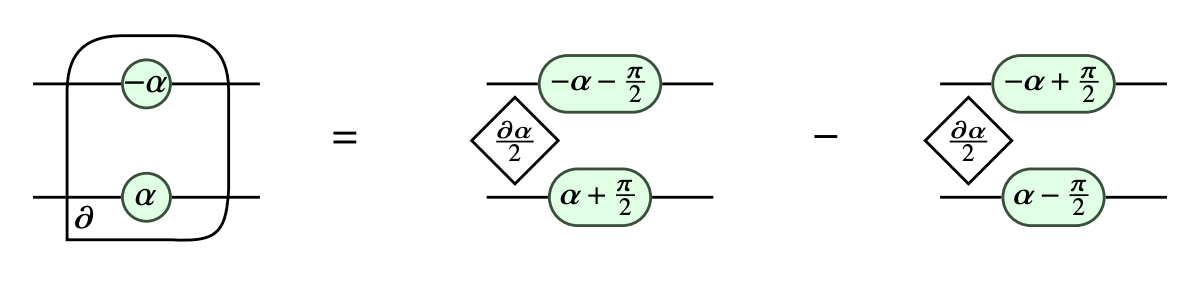

**Note:** We need a diagram for the $-1$ scalar, or formal sums with minus signs, a.k.a. enrichment in Abelian groups.

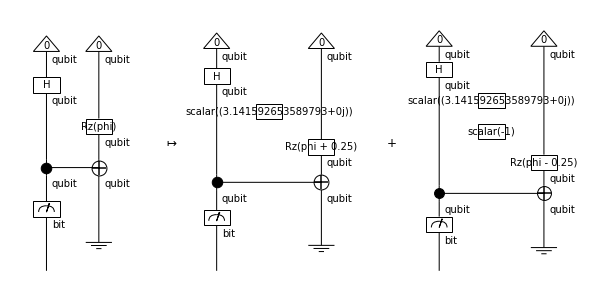

In [9]:
from sympy.abc import phi
from discopy.quantum import Measure, Discard, Rz


circuit = Ket(0, 0) >> H @ Rz(phi) >> CX >> Measure() @ Discard()

drawing.equation(circuit, circuit.grad(phi), symbol='$\mapsto$', figsize=(8, 4))

## Conclusion

* More linguistics (anaphora, ellipsis, etc.)
* More quantum (photonics, hybrid runtimes, etc.)
* More applied category theory (cognitive science and more)

_Get in touch and contribute!_